In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# Data Exploration

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

File ‘UCI-HAR.zip’ already there; not retrieving.



In [4]:
!unzip -nq UCI-HAR.zip

In [5]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [6]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x # each of 9 files gets indexed to different dimension

  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x

  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1 # subtracting 1 because Python3 is 0 indexed

  return Xtrain, Ytrain, Xtest, Ytest

In [7]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

/tmp/ipython-input-171350819.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-171350819.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-171350819.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-171350819.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-171350819.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipyth

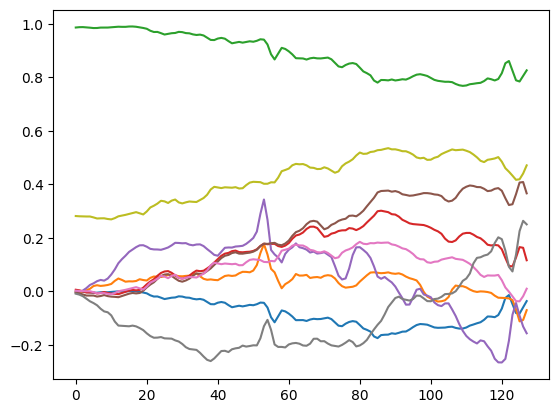

In [8]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [9]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
# x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [10]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [11]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True), # from_logits is true because we didn't do SOFTMAX after Dense for numerical stability reasons
  optimizer='adam',
  metrics=['accuracy'],
)

In [12]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=10,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5351 - loss: 1.3887

230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5359 - loss: 1.3872 - val_accuracy: 0.8463 - val_loss: 0.6197
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9005 - loss: 0.4180

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9006 - loss: 0.4177 - val_accuracy: 0.7978 - val_loss: 0.5310
Epoch 3/10
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8991 - loss: 0.3313

230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8993 - loss: 0.3308 - val_accuracy: 0.8758 - val_loss: 0.3474
Epoch 4/10
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9371 - loss: 0.2044

230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9372 - loss: 0.2042 - val_accuracy: 0.9009 - val_loss: 0.2839
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8906 - loss: 0.3375 - val_accuracy: 0.8792 - val_loss: 0.3111
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9282 - loss: 0.1925 - val_accuracy: 0.8744 - val_loss: 0.2996
Epoch 7/10
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9444 - loss: 0.1502

230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9445 - loss: 0.1501 - val_accuracy: 0.8968 - val_loss: 0.2500
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9505 - loss: 0.1348

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9505 - loss: 0.1348 - val_accuracy: 0.9013 - val_loss: 0.2337
Epoch 9/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9504 - loss: 0.1277 - val_accuracy: 0.8914 - val_loss: 0.3022
Epoch 10/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9443 - loss: 0.1413 - val_accuracy: 0.9043 - val_loss: 0.2348


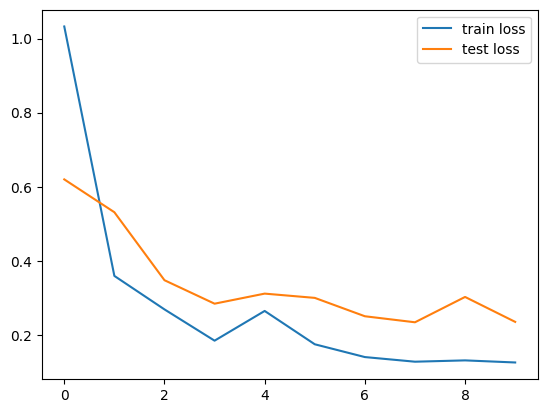

In [13]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

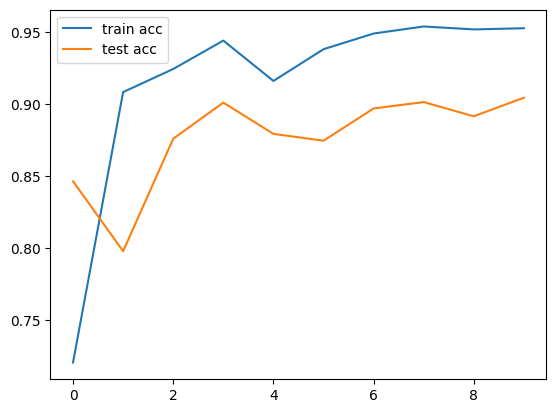

In [14]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [15]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [16]:
# make predictions
Ptest = best_model.predict(Xtest)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [17]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

np.float64(0.9012555140821175)

In [18]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)

  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)

  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [19]:
feat_train, feat_test = load_features()

/tmp/ipython-input-3714720902.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/tmp/ipython-input-3714720902.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


In [20]:
D_feat = feat_train.shape[1]

In [21]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(32, activation='relu')(i2)

x = Concatenate()([x, x2]) # we concatenate 32 dimensional output each from RNN and ANN to obtain 64 dimensional input
x = Dense(K)(x)
model = Model([i, i2], x)

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128, 32)   │      5,376 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 561)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ lstm_1[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     17,984 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        390 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,750 (92.77 KB)

 Trainable params: 23,750 (92.77 KB)

 Non-trainable params: 0 (0.00 B)

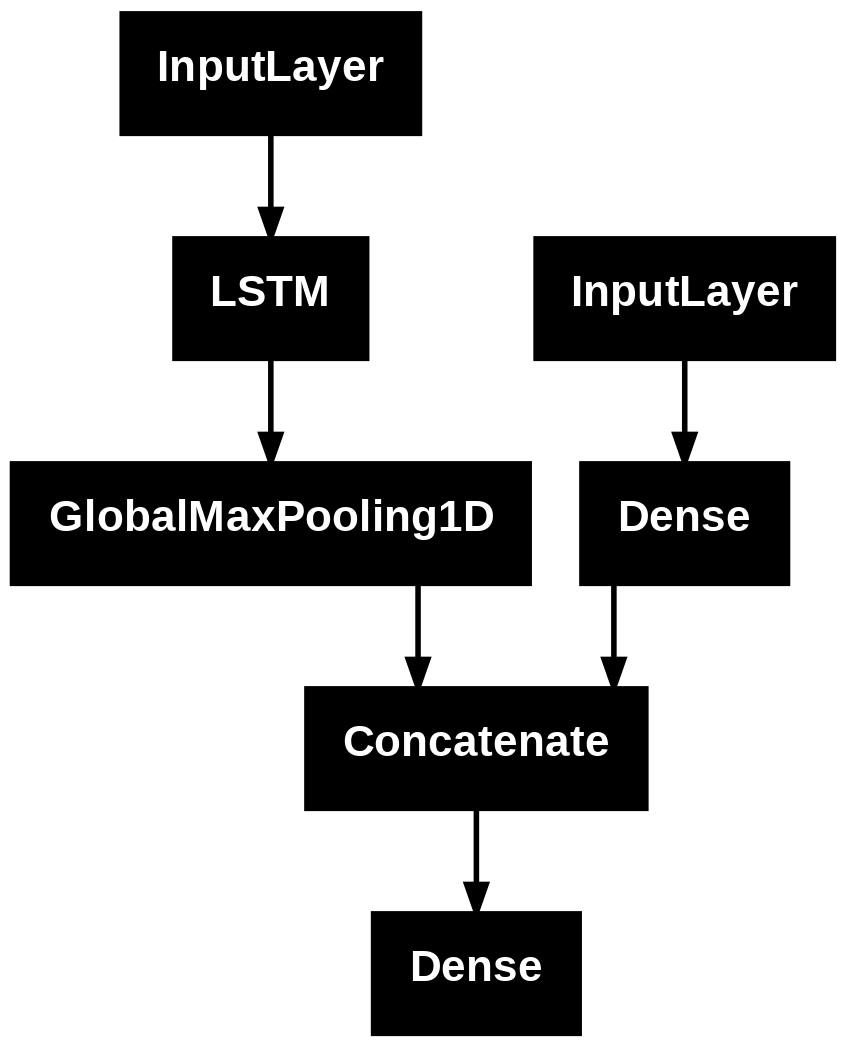

In [23]:
tf.keras.utils.plot_model(model)

In [24]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [25]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True), # from_logits is true because we didn't do SOFTMAX after Dense for numerical stability reasons
  optimizer='adam',
  metrics=['accuracy'],
)

In [26]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7561 - loss: 0.6182

230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.7566 - loss: 0.6169 - val_accuracy: 0.9315 - val_loss: 0.1891
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9619 - loss: 0.1143

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9619 - loss: 0.1142 - val_accuracy: 0.9396 - val_loss: 0.1564
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9693 - loss: 0.0782

230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9693 - loss: 0.0782 - val_accuracy: 0.9413 - val_loss: 0.1470
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9772 - loss: 0.0622

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9772 - loss: 0.0622 - val_accuracy: 0.9440 - val_loss: 0.1520
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9820 - loss: 0.0513

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9820 - loss: 0.0513 - val_accuracy: 0.9454 - val_loss: 0.1540
Epoch 6/15
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9857 - loss: 0.0440

230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9857 - loss: 0.0440 - val_accuracy: 0.9457 - val_loss: 0.1554
Epoch 7/15
229/230 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9865 - loss: 0.0390

230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9865 - loss: 0.0390 - val_accuracy: 0.9474 - val_loss: 0.1618
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9867 - loss: 0.0381 - val_accuracy: 0.9474 - val_loss: 0.1591
Epoch 9/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9888 - loss: 0.0349

230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9888 - loss: 0.0349 - val_accuracy: 0.9498 - val_loss: 0.1606
Epoch 10/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9892 - loss: 0.0327 - val_accuracy: 0.9494 - val_loss: 0.1657
Epoch 11/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9901 - loss: 0.0312 - val_accuracy: 0.9416 - val_loss: 0.1966
Epoch 12/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9876 - loss: 0.0367 - val_accuracy: 0.9474 - val_loss: 0.1801
Epoch 13/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9887 - loss: 0.0319 - val_accuracy: 0.9491 - val_loss: 0.1760
Epoch 14/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9898 - loss: 0.0270 - val_accuracy: 0.9494 - val_loss: 0.1757
Epoch 15/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9898 - loss: 0.0283 - val_accuracy: 0.9494 - val_loss: 0.1801


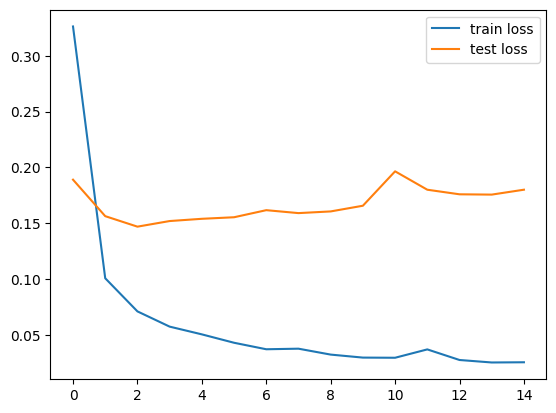

In [27]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

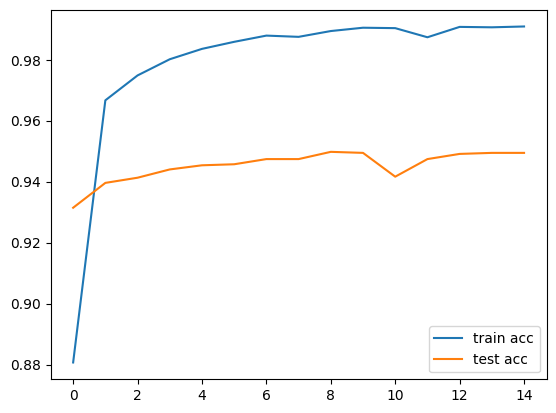

In [28]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [29]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [30]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [31]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

np.float64(0.9497794367153037)